In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
# Descargar los set de datos de Fashion MNIST de Zalando (es importante especificar los atributos as_supervised y with_info para que se descargue con todos los metadatos que necesitamos )
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [3]:
# Imprimir los metadatos para ver que trae el set para ver la información del set que acabamos de descargar y también podemos ver que aparte de la información general también trae información para el entrenamieto (60,000 datos) y para las pruebas (10,000 datos)
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    =

In [4]:
# Obtenemos en variables separadas los datos de entrenamiento (60k) y los datos de prueba (10k)
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [5]:
# Etiquetas de las 10 categorias posibles tomando la información de los metadatos
nombres_clases = metadatos.features['label'].names

In [6]:
# Imprimir los nombres de las clases o etiquetas de las 10 catergorías posibles del dataset
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
# Cuando se entrena una red, normalmente queremos normalizar los datos, es decir, hacer que todas las entradas sean en 0 y 1 lo cual ayuda mucho a acelerar el entrenamiento y mejorar los resultados
# Funcion de normalizacion para los datos (Pasar de 0-255 que son los valores de los pixeles a 0-1 siendo los datos ya normalizados)
# Hace que la red aprenda mejor y mas rapido
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 # Aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

# Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

# Agregar los datos a cache lo cual hace que el entrenamiento sea más rapido porque usa memoria en lugar de disco
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

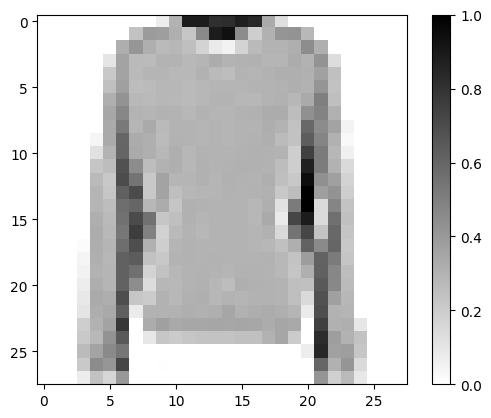

In [8]:
# Mostrar una imagen de los datos de pruebas, de momento mostremos la primera usando .take(1)
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) # Redimensionar, cosas de tensores, lo veremos despues

import matplotlib.pyplot as plt

# Dibujar dibujar
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

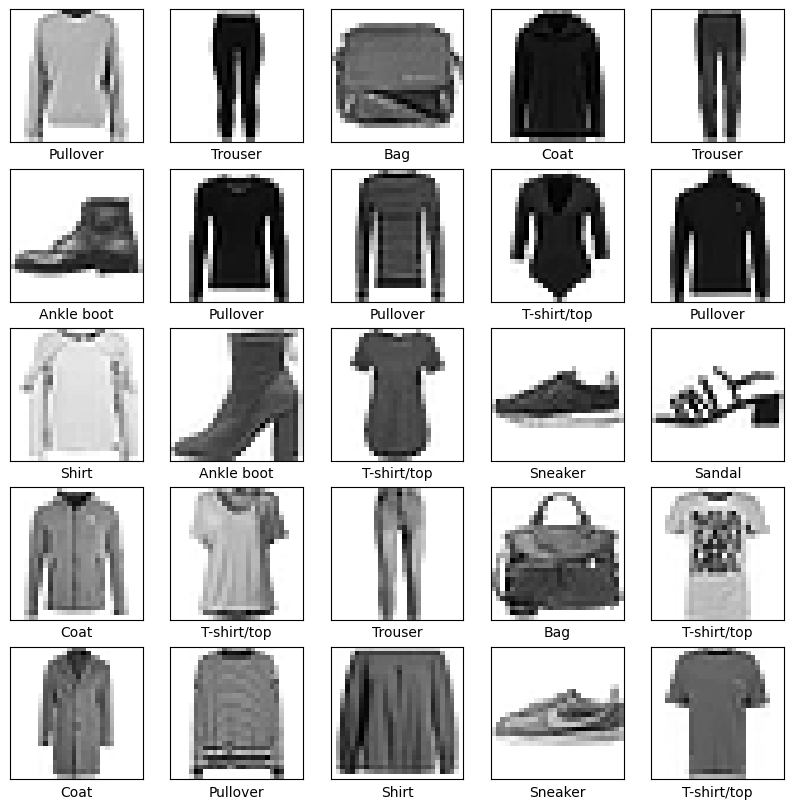

In [9]:
# Dibujar mas imágenes y que nos muestra cuál es la categoría correcta con la que la imagen viene etiquetada
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [11]:
# Crear el modelo usando una red de tipo secuencial
modelo = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28,1)), #1 - blanco y negro, la capa de entrada será definida manualmente y le colocaremos de tipo Flatten lo cual se encarga de convertir esta matriz y "aplastarla" a una sola dimensión con 784 neuronas en donde se recibirá cada pixel (porque cada imagen es de 28x28 lo cual si multiplicamos nos da 28 x 28 = 784 lo cual será cada neurona de entrada)
  tf.keras.layers.Dense(50, activation=tf.nn.relu), # función de activación relu
  tf.keras.layers.Dense(50, activation=tf.nn.relu), # función de activación relu
  tf.keras.layers.Dense(10, activation=tf.nn.softmax) # función de activación softmax que en pocas palabras se usa como función de activación en la capa de salida en las redes de clasificación para asegurar que la suma de las neuronas de salida siempre nos de un 1
])

In [12]:
# Compilar el modelo
modelo.compile(
    optimizer='adam', # función de optimización adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), # para la función de pérdida se usará SparseCategoricalCrossentropy ya que también es usada en las redes de clasificación
    metrics=['accuracy']
)

In [13]:
# Colocar en variables los numeros de datos en entrenamiento y pruebas (60k y 10k)
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

In [14]:
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [15]:
# Entrenar una red con pocos datos como 7 o 10 elementos es muy facil, pero ahora tenemos 70k de ejemplos entonces para decirle que la red entrene más rápido le podemos decir que entrene en lotes. El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
TAMANO_LOTE = 32

# Ajustar algunas propiedades de los datos de entrenamiento y pruebas
# Como daremos varias vueltas al set de datos en el entrenamiento entonces queremos que se haga de forma aleatoria y no siempre en un mismo orden y para eso usaremos repeat y shuffle hacen que los datos esten mezclados de manera aleatoria para que la red no se vaya a aprender el orden de las cosas y con batch le diremos el tamaño del lote de entrenamiento para que se pueda hacer más rápido
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE) # aquí solo usaremos la función de batch

In [16]:
import math

# Entrenar a nuestra red usando la función fit en donde vamos a especificar los datos de entrenamiento, vueltas/iteraciones que queremos darle a los datos
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch= math.ceil(num_ej_entrenamiento/TAMANO_LOTE)) # idealmente deberíamos terminar con una presición de alrededor o superior a 88% que sería 0.88

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7605 - loss: 0.6992
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8600 - loss: 0.3913
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8701 - loss: 0.3531
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8793 - loss: 0.3270
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8867 - loss: 0.3148


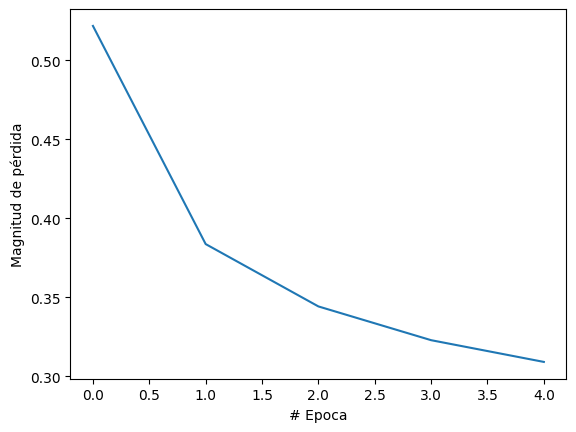

In [17]:
# Ver la funcion de perdida en cada época
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


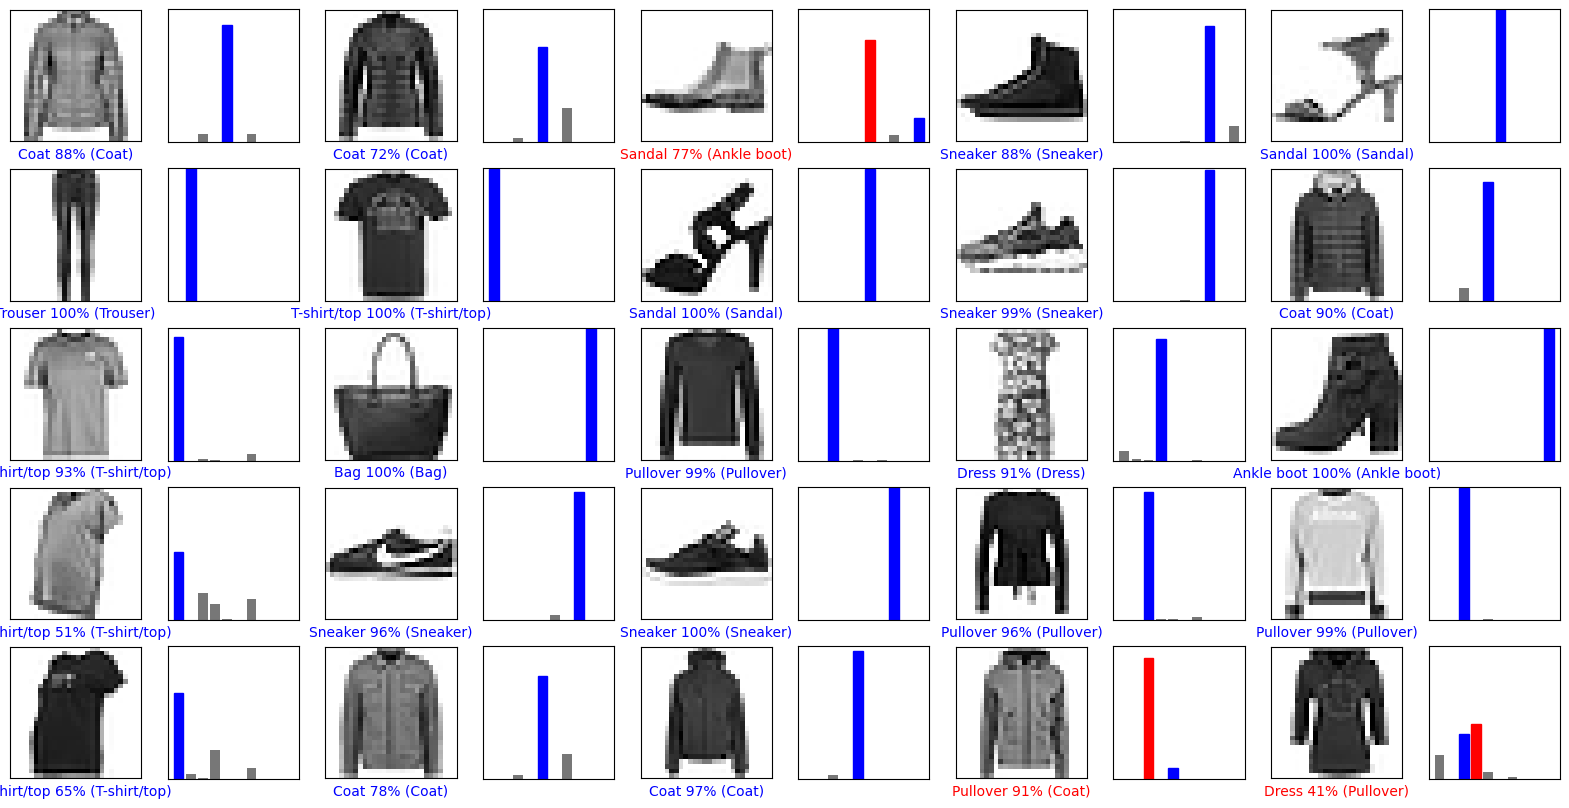

In [18]:
# Ahora el modelo está listo para realizar predicciones y lo podemos hacer de varias formas:

# FORMA 1: aquí en Google Colap con los datos de prueba
# Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue' # sí acertó la predicción
  else:
    color = 'red' # no acertó la predicción

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [19]:
# Probar una imagen suelta tomando cualquier índice del set de pruebas para ver su predicción
imagen = imagenes_prueba[4] # Al ser la variable imagenes_prueba solo tiene lo que se le puso en el bloque anterior
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediccion: Sandal


In [20]:
# FORMA 2: exportar el modelo entrenado para probarlo por ejemplo, en un navegador web usando tensorflow.js
# Exportacion del modelo a h5
modelo.save('modelo_exportado.h5') # haciéndolo así nos saldrá un warning similar a "..... UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`....."

In [ ]:
# Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
!pip install tensorflowjs

In [ ]:
# Convertir el archivo h5 a formato de tensorflowjs
!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

In [ ]:
# Veamos si si creo la carpeta
!ls

In [ ]:
# Veamos el contenido de la carpeta
!ls tfjs_target_dir

In [ ]:
# Ahora en una página web se podría importar el modelo para que funcione en el explorador